In [1]:
import os
from itertools import islice

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm_notebook as tqdm

import torch
from torch.utils.data import TensorDataset, DataLoader

import sklearn
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

import zuko
import lampe.inference
import lampe.utils


In [2]:
# C'était pour comparer avec les données du papier, pas nécessaire pour le RNPE
data_papier = np.load("/home/tux/rnpe/data.npy",allow_pickle=True)
data_papier.item().keys()

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


dict_keys(['theta', 'theta_true', 'x', 'y', 'y_raw'])

In [3]:
prior_over_mu = torch.distributions.Normal(torch.zeros(1), torch.ones(1)*5)

In [4]:
# Là aussi
mu = data_papier.item()['theta_true'].item()
mu = prior_over_mu.sample().item()

theta_papier = data_papier.item()['theta']

x_papier = data_papier.item()['x']

y_papier = data_papier.item()['y']

y_raw_papier = data_papier.item()['y_raw']

In [5]:
#mu=0

In [6]:
N = 50000
sigma = 0.01
tau = 0.25
rho = 1/2

Utils

In [32]:
def generate_observed_corrupted_data(N: int, mu: float, sigma_2: float) -> torch.Tensor:
    """Generates the corrupted "y" from N(mu, sigma²)

    Args:
        N (int): Number of observations
        mu (float): True parameter
        sigma² (float): Variance of the y

    Returns:
        torch.Tensor: tensor of y, dim(N, 2)
    """
    zx = mu + torch.distributions.Normal(0, 1).sample((N, 100)) #N(mu,1)
    epsilon = np.sqrt(sigma_2-1)
    zy = zx + torch.distributions.Normal(0, epsilon).sample(zx.shape)#N(mu, 1+epsilon)
    y_raw = torch.cat((zy.mean(dim=1, keepdim=True), zy.var(dim=1, keepdim=True)), dim=-1)
    return y_raw

In [8]:
def simulator(N_train: int,N_test: int, prior: torch.distributions) -> tuple:
    """Generates x as a summary (mea, var) of samples from N(theta, 1), theta ~ prior

    Args:
        N_train (int): Number of simulation for the train
        N_test (int): Number of simulation for the test
        prior (torch.distributions): prior over theta

    Returns:
        tuple (torch.Tensor, torch.Tensor): theta dim(N,), x_raw dim(N,2): the thetas and their correspond x
    """
    N = N_train + N_test
    theta = prior.sample((N, ))
    sample = torch.distributions.Normal(theta, 1.0).sample((100, )) #N(theta,1)
    x_raw = torch.cat((sample.mean(dim=0, keepdim=True), sample.var(dim=0, keepdim=True)), dim=-1).squeeze_()
    return theta, x_raw


In [9]:
def scale(quantity):
    means = quantity.mean(0)
    stds = quantity.std(0)
    return (quantity-means)/stds, means, stds

In [10]:
#Splitting theta,x into train & test sets, and scaling them
theta_raw_f, x_raw_f = simulator(N, N//10, prior_over_mu)
x_raw, x_test_raw = x_raw_f.split(N)
x, x_mean, x_std = scale(x_raw)
x_test, x_test_mean, x_test_std = scale(x_test_raw)
theta, theta_test = theta_raw_f.split(N)
theta, theta_mean, theta_std = scale(theta)
theta_test, theta_test_mean, theta_test_std = scale(theta_test)

dataset = lampe.data.JointDataset(theta, x)
dataset_test = lampe.data.JointDataset(theta_test, x_test)

In [44]:
#Generating the observed corrupted data y 
sigma_2 = 2
y_raw = generate_observed_corrupted_data(N, mu, sigma_2)
#Taking y0 a particular observation
y = (y_raw[0] - x_mean) / x_std
y

tensor([0.0188, 6.1110])

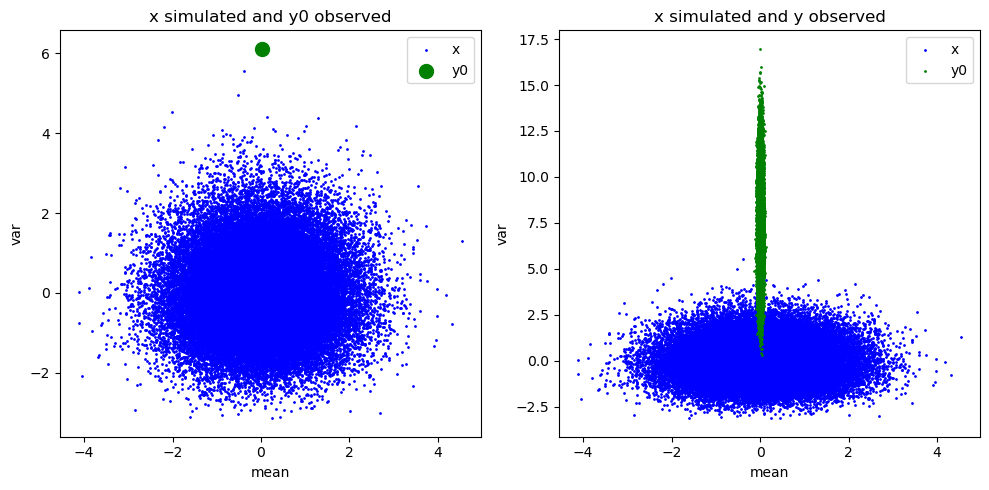

In [45]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].scatter(x=x[:, 0], y=x[:, 1], color='blue', label="x", s=1)
axs[0].scatter(x=y[0], y=y[1], color='green', label="y0", s=100)
axs[0].set_xlabel("mean")
axs[0].set_ylabel("var")
axs[0].set_title("x simulated and y0 observed")
axs[0].legend()

axs[1].scatter(x=x[:, 0], y=x[:, 1], color='blue', label="x", s=1)
axs[1].scatter(x=(y_raw[:, 0] - x_mean[0]) / x_std[0], y=(y_raw[:, 1] - x_mean[1]) / x_std[1], color='green', label="y0", s=1)
axs[1].set_xlabel("mean")
axs[1].set_ylabel("var")
axs[1].set_title("x simulated and y observed")
axs[1].legend()

plt.tight_layout()  
plt.show()

It looks like Figure 1, the simulator is indeed miss specified on y var axis

In [13]:
def train_NPE(flow: lampe.inference.NPE, data: lampe.data.JointDataset, loss: callable,theta_test: torch.Tensor, x_test: torch.Tensor, learning_rate: float=5*10e-4, max_epochs: int=50,batch_size: int=256, patience: int=5) -> lampe.inference.NPE:
    """Trains a NPE.

    Args:
        flow (lampe.inference.NPE): A instanciated flow
        data (lampe.data.JointDataset): dataset (theta, x)
        loss (callable): a loss function
        theta_test (torch.Tensor): test batch
        x_test (torch.Tensor): test batch
        learning_rate (float, optional): Default is 5*10e-4.
        max_epochs (int, optional): Default is 50.
        batch_size (int, optional): Default is 256.
        patience (int, optional): Default is 5.

    Returns:
        lampe.inference.NPE: the trained NPE
    """
    
    #Optim
    optimizer = torch.optim.Adam(flow.parameters(), learning_rate)
    #Creates the loader
    loader = lampe.data.DataLoader(data, batch_size)
    #For early stopping
    with torch.no_grad():
        min_loss = loss(theta_test,x_test)
    min_loss_list = [min_loss]
    
    flow.train()

    for epoch in tqdm(range(max_epochs),"q_NPE training"):
        
        for theta_batch, x_batch in loader:
            
            losses = loss(theta_batch, x_batch)
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
        
        #Checking for early stopping
        with torch.no_grad():
            loss_test = loss(theta_test, x_test)
            min_loss_list.append(loss_test)
            if len(min_loss_list) - np.argmin(min_loss_list) > patience: #No improvement in loss(test) for the last patience iterations
                print(f" Early stop at epoch {epoch}")
                break
    flow.eval()
    return flow

In [14]:
def train_unconditional(flow: zuko.flows, x: torch.Tensor, x_test: torch.Tensor, loss: callable, learning_rate: float=1e-2,max_epochs: int=50, batch_size: int=256, patience: int=5) -> zuko.flows:
    """Train an unconditional flow

    Args:
        flow (zuko.flows): A instanciated flow
        x (torch.Tensor): 
        x_test (torch.Tensor): test batch
        loss (callable): a loss function
        learning_rate (float, optional): Defaults to 1e-3.
        max_epochs (int, optional): Defaults to 50.
        batch_size (int, optional): Defaults to 256.
        patience (int, optional): Defaults to 5.

    Returns:
        zuko.flow: the trained flow
    """
    
    #Optim
    optimizer = torch.optim.Adam(flow.parameters(), learning_rate)
    
    #Creates the loader
    loader = torch.utils.data.DataLoader(x, batch_size)
    min_loss_list = []
    #Early stopping
    with torch.no_grad():
        min_loss = loss(x_test)
    min_loss_list = [min_loss]
    
    flow.train()
    for epoch in tqdm(range(max_epochs),"q_x training"):
        
        for x_batch in loader:
        
            losses = loss(x_batch)
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
        #Checking for early stopping
        with torch.no_grad():
            loss_test = loss(x_test)
            min_loss_list.append(loss_test)
            if len(min_loss_list) - np.argmin(min_loss_list) > patience:
                print(f"Early stop at epoch {epoch}")
                break
    return flow

Train NPE q(theta|x) on the simulated dataset {(thetai, xi)}, i=1, ... N
Uses a neural spline flow defining the transform on the interval [-5, 5] using 10  spline segments and 5 coupling layers. The base of the flow is a standard Gaussian distribution. 

In [46]:
def build_nsf(features, context):
    """Callable to instanciate the NPE with NSFs"""
    return zuko.flows.NSF(features, context, bins=10, transforms=5)

q_NPE = lampe.inference.NPE(theta_dim = 1, x_dim=2, build=build_nsf)
loss_NPE = lampe.inference.NPELoss(q_NPE)
q_NPE = train_NPE(q_NPE, dataset, loss_NPE, theta_test, x_test)

q_NPE training:   0%|          | 0/50 [00:00<?, ?it/s]

 Early stop at epoch 11


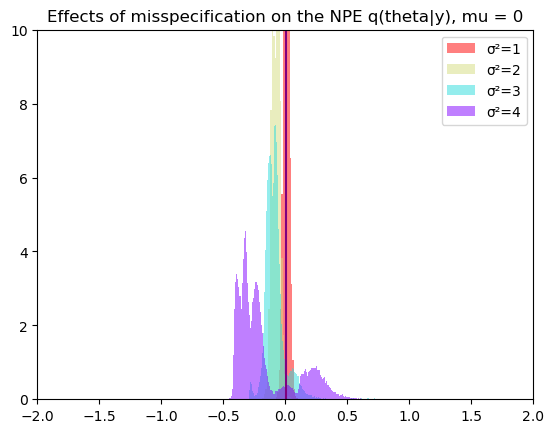

In [49]:
def plot_corruption_effect(sigmas_2: list, npe: lampe.inference.NPE) -> None:
    """Plots θ~q(θ|y), y~N(mu, sigmas_2)

    Args:
        sigmas_2 (list)
        npe (lampe.inference.NPE)
    """
    d = {}    
    for sigma_2 in sigmas_2:
        #Generating the y
        y = generate_observed_corrupted_data(N,mu,sigma_2)[0]
        y = (y - x_mean) / x_std
        d[sigma_2] = npe.sample(y, (N, ))

    colors = plt.cm.rainbow_r(np.linspace(0, 1, len(d)))
    for i, (sigma_2, posterior) in enumerate(d.items()):
        plt.hist(posterior.detach().numpy(), bins=400, alpha=0.5, color=colors[i], label=f"σ²={sigma_2}", density=True)
    plt.axvline((mu-theta_mean)/theta_std,color='purple')
    plt.legend()
    plt.ylim(top=10)
    plt.xlim(-2, 2)
    plt.title(f"Effects of misspecification on the NPE q(theta|y), mu = {mu}")
    plt.show()
        
plot_corruption_effect([1,2,3,4], q_NPE)
        

For some run the estimated densities all look ~gaussian but for some it does not...
From my observations:
It looks more gaussian when the q_NPE stops training early (~9-10 iter) and does not look gaussien when the training is stopped later (~epoch 30)

### Sampling theta here as in the classic NPE framework

In [50]:
thetas_NPE = q_NPE.sample(y, (N, ))

Train q(x) on {xi} i=1, ... N (so first gen the x)
For q(x) uses of a block neural autoregressive flow, single hidden layer of size 8D, x in R^d

In [51]:
q_x_NF = zuko.flows.NAF(features = 2, context=0, hidden_features=[8]*2, passes=2)
loss_q_x = lambda x: -q_x_NF().log_prob(x).mean()
q_x_NF = train_unconditional(q_x_NF, x, x_test, loss_q_x)

q_x training:   0%|          | 0/50 [00:00<?, ?it/s]

Early stop at epoch 8


Sample x~m from p(x | y0) % p(y0 \ x) q(x), m = 1, ... M using MCMC

Spike and slab

In [52]:
M = 100000
warm_up_steps = 20000
traj_length = 1
target_acceptance_prob = 0.95

In [53]:
#Utilisée avant pour comparer les échantillons
def compare(flow,x,file):
    class1 = file
    post = flow.flow(x).sample((class1.shape[0], ))
    print(post.shape)
    #post = scale(post)
    post_array = post.detach().numpy()
    class0 = post_array
    class0_labels = np.zeros(len(class0))
    class1_labels = np.ones(len(class1))
    data = np.concatenate((class0,class1), axis=0)
    labels = np.concatenate((class0_labels, class1_labels), axis=0)
    X_train, X_test, y_train, y_test = train_test_split(data,labels)

    clf = QuadraticDiscriminantAnalysis()
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    acc = sklearn.metrics.accuracy_score(y_test,y_pred)
    return acc
    

MCMC

In [54]:
def proposal(x_curr):
    with torch.no_grad():
        
        return x_curr + torch.distributions.Normal(0,1).sample(x_curr.shape)


def f(y0, x): #% to p(x |y0)
    D = 2
    res = torch.zeros_like(y0,requires_grad=False)

    for j in range(D):
        xj = x[j]
        yj = y0[j]
        zj = torch.distributions.Bernoulli(rho).sample()
        if not zj:
            spike_dist =  torch.distributions.Normal(xj.detach(), torch.tensor(sigma))
            res[j] = torch.exp(spike_dist.log_prob(yj))
        else:
            
            slab_dist = torch.distributions.Cauchy(xj.detach(), torch.tensor(tau))
            res[j] = torch.exp(slab_dist.log_prob(yj))
    return res*torch.exp(q_x_NF().log_prob(x))


def mcmc(x0, warm_up_steps, M, y0):
    x_curr = x0
    my_samples = torch.empty((warm_up_steps+M, x0.shape[0]), requires_grad=False)
    log_f_x_curr = f(y0, x_curr).log()
    for i in tqdm(range(warm_up_steps+M),"Sampling xm using MH algorithm"):
        x_star = proposal(x_curr)
        log_f_x_star = f(y0, x_star).log()

        log_a = log_f_x_star - log_f_x_curr

        a = torch.exp(log_a)

    
        u = torch.rand(a.shape).to(a)

        mask = u < a

        x_curr = torch.where(mask, x_star, x_curr)
        log_f_x_curr = torch.where(mask, log_f_x_star, log_f_x_curr)
    
        my_samples[i] = x_curr
    my_samples = my_samples[warm_up_steps:]
    return my_samples


with torch.no_grad():    
    my_samples = mcmc(torch.zeros_like(x[0]), warm_up_steps, M, y)
# 9 min to run 

Sampling xm using MH algorithm:   0%|          | 0/120000 [00:00<?, ?it/s]

In [55]:
thetas_m = q_NPE.sample(my_samples)

<Axes: ylabel='Density'>

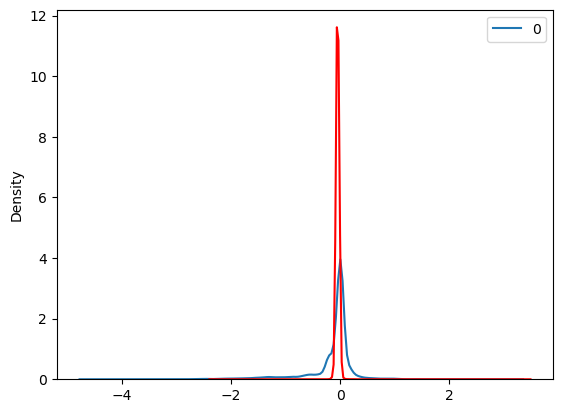

In [56]:
sns.kdeplot(thetas_m)
sns.kdeplot(thetas_NPE.squeeze(),c='red')

/home/tux/miniconda3/envs/rnpe_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.asarray(x, float)


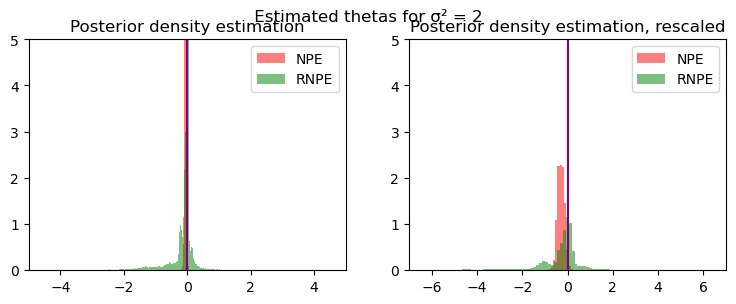

In [58]:
def plot_thetas_scaled(thetas_NPE, thetasm, theta_mean, theta_std, sigma_2): 
    plt.close()
    n_bins= 300
    plt.close()
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(9, 3))
    
    ax1.hist(thetas_NPE.squeeze().detach().numpy(),bins=n_bins, alpha=0.5, color='r', label='NPE', density=True)
    ax1.hist(thetasm.squeeze().detach().numpy(),bins=n_bins, alpha = 0.5, color='g', label='RNPE', density=True)
    mu_sclaled = (mu - theta_mean)/theta_std
    ax1.axvline(x=mu_sclaled,color="purple")
    ax1.axis(xmin=-5,xmax= 5)
    ax1.axis(ymax=5)
    ax1.legend()
    ax1.set_title("Posterior density estimation")
    
    ax2.hist(((thetas_NPE.squeeze() + theta_mean)*theta_std).detach().numpy(), bins=n_bins,alpha=0.5, color='r', label='NPE',density=True)
    ax2.hist(((thetasm.squeeze()+theta_mean)*theta_std).detach().numpy(), bins=n_bins, alpha=0.5, color='g', label='RNPE', density=True)
    ax2.axis(xmin=-7,xmax= 7)
    ax2.axis(ymax=5)
    ax2.axvline(x=mu,color="purple")
    ax2.legend()
    ax2.set_title("Posterior density estimation, rescaled")
    
    fig.suptitle(f" Estimated thetas for σ² = {sigma_2}")
    fig.show()
    

plot_thetas_scaled(thetas_NPE, thetas_m, theta_mean, theta_std, sigma_2)#,thetas_NPE_noisy)


Text(0.5, 1.0, 'Simulated, denoised, and observed data')

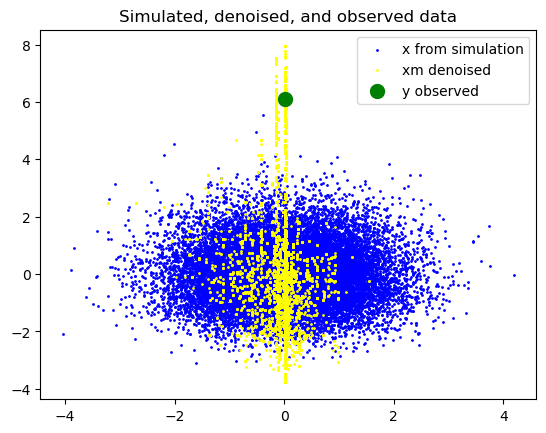

In [59]:
plt.scatter(x=x[:20000,0], y=x[:20000,1], color='blue', label="x from simulation", s=1)
plt.scatter(x=my_samples[:20000,0], y=my_samples[:20000,1], color='yellow', s=1, label="xm denoised")
plt.scatter(x=y[0],y=y[1],color='green',label="y observed", s=100)
plt.legend()
plt.title("Simulated, denoised, and observed data")

<Axes: ylabel='Density'>

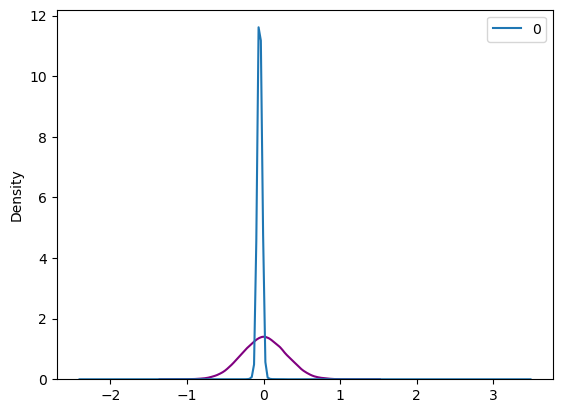

In [60]:
n = 1
mu_theory = ((y[0]*n)/(1+epsilon)) * (1/25 + n/(1+epsilon)**(-1))
std_theory = np.sqrt((1/25 + n/(1+epsilon)**(-1)))
true_post = torch.distributions.Normal(mu_theory, std_theory)
true_post_samples = (true_post.sample((N, )) - theta_mean)/theta_std

sns.kdeplot(true_post_samples.detach().numpy(), color='purple')
sns.kdeplot(thetas_NPE.detach().numpy(), color='red')

Until now the RNPE was for a single epsilon, the following sections runs the RNPE for several epsilons to compare the results

In [61]:
sigmas_2 = [1, 2, 3, 4]
def pipeline(sigmas_2, mu):
    """Carry on the whole algorithm for every epsilon

    Args:
        epsilons (iterable): sequence of epsilons
        mu (float): true parameter

    Returns:
        dict: dict with 'theta_mean', 'theta_std', 'epsilon''theta_NPE', 'epsilon''theta_RNPE'
    """
    res = {}
    M = 100000
    warm_up_steps = 20000
    print("Simulations")
    theta_raw_f, x_raw_f = simulator(N, N//10, prior_over_mu)
    x, x_test = x_raw_f.split(N)
    x, x_mean, x_std = scale(x)
    x_test, x_test_mean, x_test_std = scale(x_test)
    theta, theta_test = theta_raw_f.split(N)
    theta, theta_mean, theta_std = scale(theta)
    res['theta_mean'] = theta_mean
    res['theta_std'] = theta_std
    theta_test, theta_test_mean, theta_test_std = scale(theta_test)
    dataset = lampe.data.JointDataset(theta, x)
    dataset_test = lampe.data.JointDataset(theta_test, x_test)

    q_NPE = lampe.inference.NPE(theta_dim = 1, x_dim=2, build=build_nsf)
    loss_NPE = lampe.inference.NPELoss(q_NPE)
    q_NPE = train_NPE(q_NPE, dataset, loss_NPE, theta_test, x_test)
    
    q_x_NF = zuko.flows.NAF(features = 2, context=0, hidden_features=[8]*2)
    loss_q_x = lambda x: -q_x_NF().log_prob(x).mean()
    q_x_NF = train_unconditional(q_x_NF, x, x_test, loss_q_x, patience=10)
    
    
    print("Sampling from q_x")
    x_props = q_x_NF().sample((warm_up_steps+M, ))
    x_props = x_props[~x_props.isinf().any(dim=1)]

    for sigma_2 in tqdm(sigmas_2):
        res[sigma_2] = {}
        print(f"sigma_2 = {sigma_2}\n")
        y_raw = generate_observed_corrupted_data(N, mu, sigma_2)
        y = (y_raw[0] - x_mean) / x_std
        with torch.no_grad():
            
            xm = mcmc(torch.zeros_like(x[0]), warm_up_steps, M, y)
        
        print("Sampling theta_m")
        thetas_m = q_NPE.sample(xm)
        print("Sampling from q_NPE")
        thetas_NPE = q_NPE.sample(y, (N, ))
        res[sigma_2]['theta_NPE'] = thetas_NPE
        res[sigma_2]['theta_RNPE'] = thetas_m
    return res


res_path = "results.npy"

if os.path.isfile(res_path):
    user_input = input("Re run pipeline and Overwrite results ? (y/n): ")
    if user_input.lower() != "y":
        exit()
    else:
        print("Overwriting")
        os.remove(res_path)
        res = pipeline(sigmas_2,0)
        np.save(res_path, res)
else:
    res = pipeline(sigmas_2,0)
    np.save(res_path, res)

        

Overwriting
Simulations


q_NPE training:   0%|          | 0/50 [00:00<?, ?it/s]

 Early stop at epoch 6


q_x training:   0%|          | 0/50 [00:00<?, ?it/s]

Early stop at epoch 22
Sampling from q_x


  0%|          | 0/4 [00:00<?, ?it/s]

Epsilon = 1



Sampling xm using MH algorithm:   0%|          | 0/120000 [00:00<?, ?it/s]

Sampling theta_m
Sampling from q_NPE
Epsilon = 2



Sampling xm using MH algorithm:   0%|          | 0/120000 [00:00<?, ?it/s]

Sampling theta_m
Sampling from q_NPE
Epsilon = 3



Sampling xm using MH algorithm:   0%|          | 0/120000 [00:00<?, ?it/s]

Sampling theta_m
Sampling from q_NPE
Epsilon = 4



Sampling xm using MH algorithm:   0%|          | 0/120000 [00:00<?, ?it/s]

Sampling theta_m
Sampling from q_NPE


In [62]:
import ipywidgets as widgets
%matplotlib inline

In [64]:
@widgets.interact(sigma_2=(1,4,1))
def plot_npe_rnpe(sigma_2=2):
    
    res_path = "results.npy"
    res = np.load(res_path, allow_pickle=True)
    npe = res.item()[sigma_2]['theta_NPE']
    rnpe = res.item()[sigma_2]['theta_RNPE']
    theta_mean = res.item()['theta_mean']
    theta_std = res.item()['theta_std']
    plot_thetas_scaled(npe,rnpe,theta_mean,theta_std,sigma_2)


interactive(children=(IntSlider(value=2, description='sigma_2', max=4, min=1), Output()), _dom_classes=('widge…

/tmp/ipykernel_276/1313063902.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f"plot_{sigma}.png"))


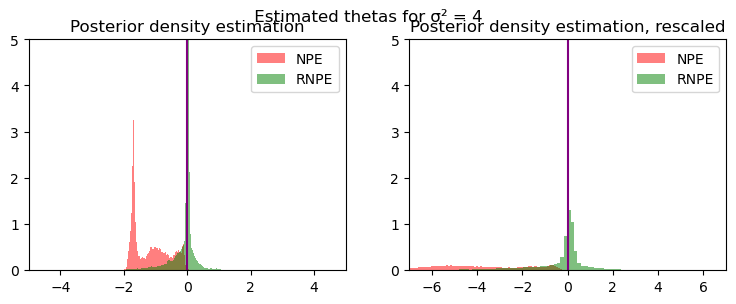

In [70]:
import imageio

# Liste pour stocker les images individuelles
images = []

# Appel à la fonction interact pour générer les graphiques et les enregistrer comme images
for sigma in range(1, 5):
    plot_npe_rnpe(sigma_2=sigma)
    plt.savefig(f"plot_{sigma}.png")  # Enregistre l'image en PNG
    images.append(imageio.imread(f"plot_{sigma}.png"))

# Enregistre les images en tant que GIF
imageio.mimsave("widget.gif", images, duration=2000.0)